In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# user defined.
from helpful_functions import MLFunctions

In [3]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    parse_dates=['date'])

In [5]:
sales = sales.sort_values(by='date')

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
16164,01.01.2013,0,28,11613,1499.0,1.0
101474,01.01.2013,0,51,10283,667.0,1.0
10197,01.01.2013,0,19,2828,499.0,1.0
101457,01.01.2013,0,51,10390,150.0,1.0
101455,01.01.2013,0,51,10591,110.0,1.0


In [25]:
average_items_sold = sales.groupby('date').mean()['item_cnt_day']

In [27]:
df = average_items_sold.to_frame()

In [43]:
df.index = pd.to_datetime(df.index, format="%d.%m.%Y")

In [47]:
df = df.sort_index()

In [19]:
time = np.arange(len(df.index))
df['time'] = time

In [23]:
X = df.loc[:, ['time']]
y = df.loc[:, 'item_cnt_day']

In [25]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [27]:
y_pred = pd.Series(model.predict(X), index=X.index)

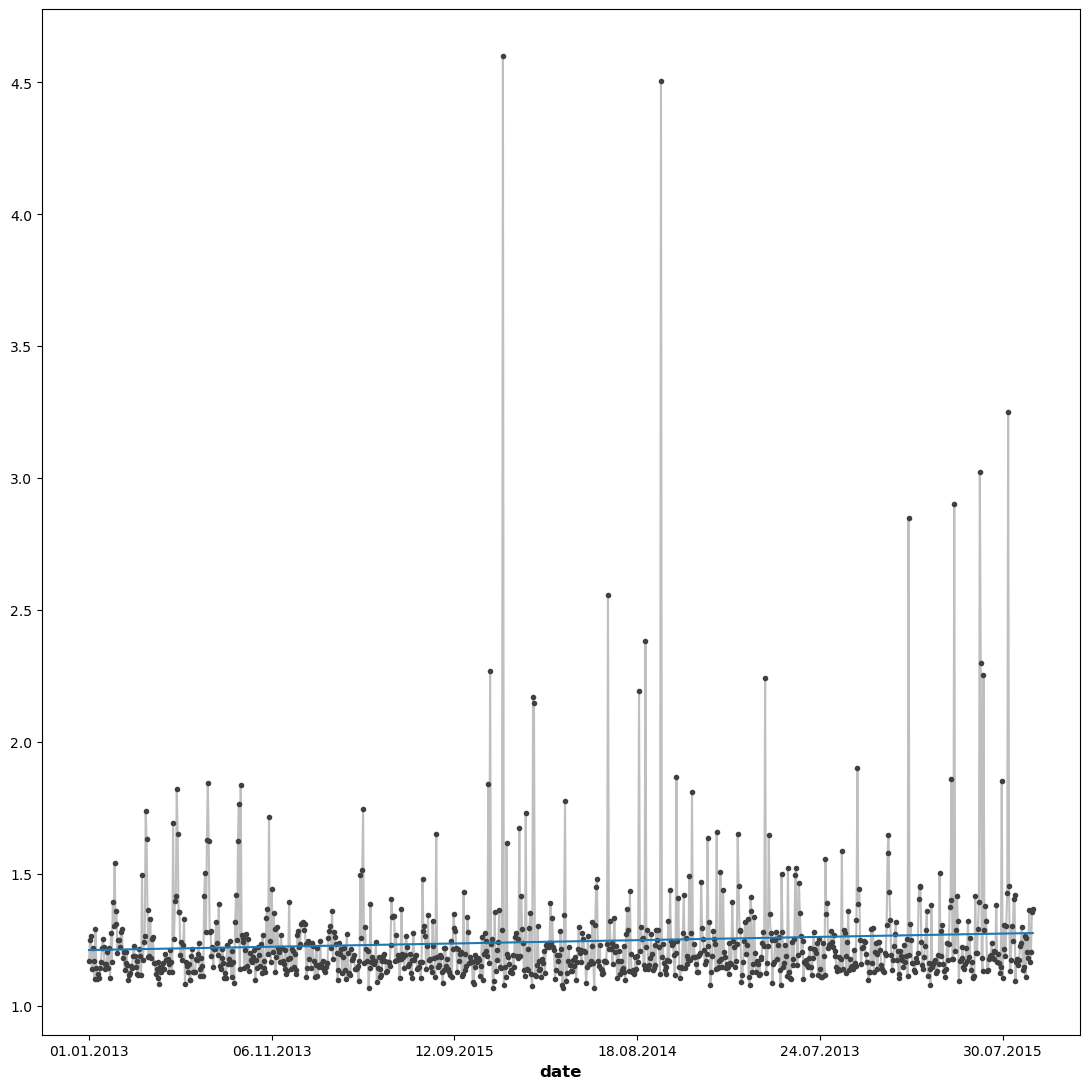

In [29]:
import matplotlib.pyplot as plt
plt.rc("figure", autolayout=True, figsize=(11, 11))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax)

In [33]:
df2 = average_items_sold.to_frame()

In [76]:
lag_1 = df2['item_cnt_day'].shift(1)
df2['lag_1'] = lag_1
X = df2.loc[:, ['lag_1']].dropna()
y = df2.loc[:, 'item_cnt_day']

In [78]:
y, X = y.align(X, join='inner')

In [80]:
model2 = LinearRegression()
model2.fit(X,y)

LinearRegression()

In [82]:
y_pred = pd.Series(model2.predict(X), index=X.index)

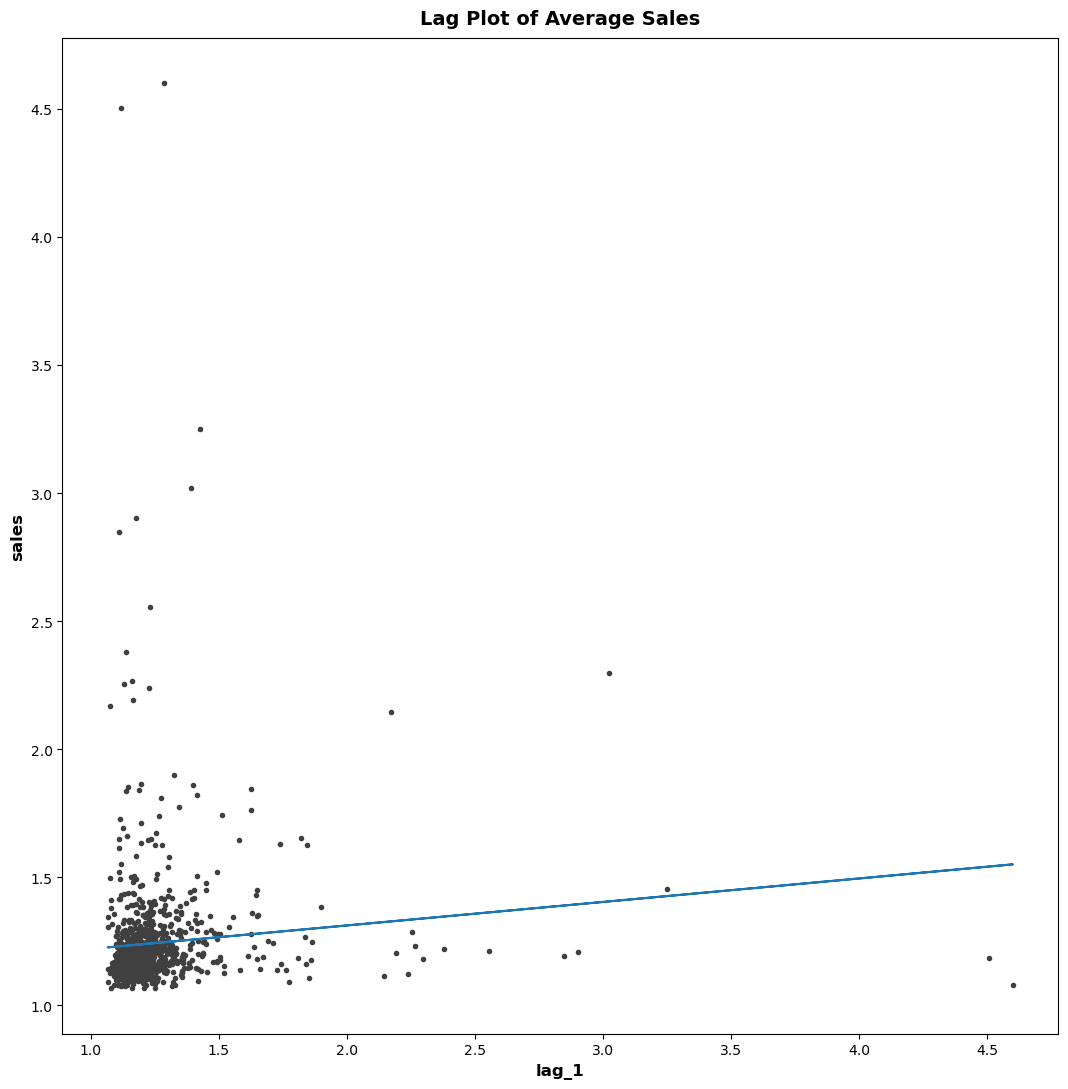

In [84]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [3]:
# use MLfunction class to convert date to equivalent dummy time.
user_function = MLFunctions(sales)
date_num = user_function.dateNum()

In [4]:
# create new column with numeric values equivalent to dates. 
sales["date_num"] = date_num

In [5]:
sales = sales.sort_values(by="date_num")

In [6]:
sales["lag_features"] = sales["item_cnt_day"].shift(30)

In [7]:
sales = sales.dropna()

In [8]:
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_num,lag_features
date,,,,,,,
02.01.2013,0,41,17481,1199.62,1.0,0,1.0
02.01.2013,0,56,15013,249.00,1.0,0,1.0
02.01.2013,0,31,1830,599.00,3.0,0,1.0
02.01.2013,0,31,1987,599.00,2.0,0,1.0
02.01.2013,0,41,18539,199.00,1.0,0,1.0


In [9]:
# split sales into train and test sets. 
train_set, test_set = train_test_split(sales, test_size=0.2, random_state=44)

In [10]:
# training and test data created.
X_train = train_set.loc[:, ["date_block_num", "shop_id", "item_id", "item_price", "date_num", "lag_features"]]
y_train = train_set["item_cnt_day"]
X_test = test_set.loc[:, ["date_block_num", "shop_id", "item_id", "item_price", "date_num", "lag_features"]]
y_test = test_set["item_cnt_day"]

In [11]:
# adds additional features to fit the nonlinear data.
poly_feat = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)

In [12]:
# ensures that columns have same scale.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [13]:
# linear regression without polynomial features.
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# measures training error.
sales_predictions_train = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(sales_predictions_train, y_train)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.6181997067795906

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


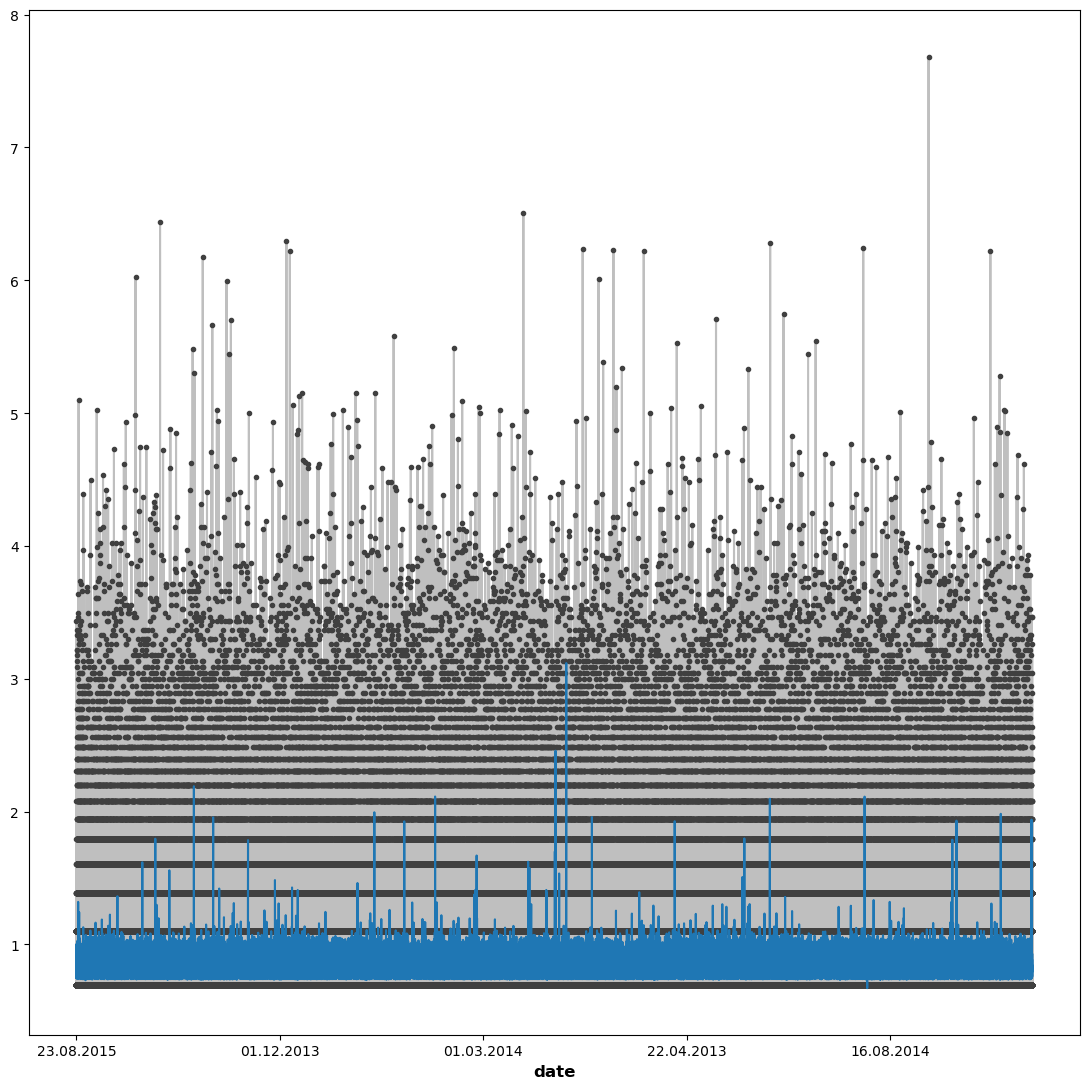

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


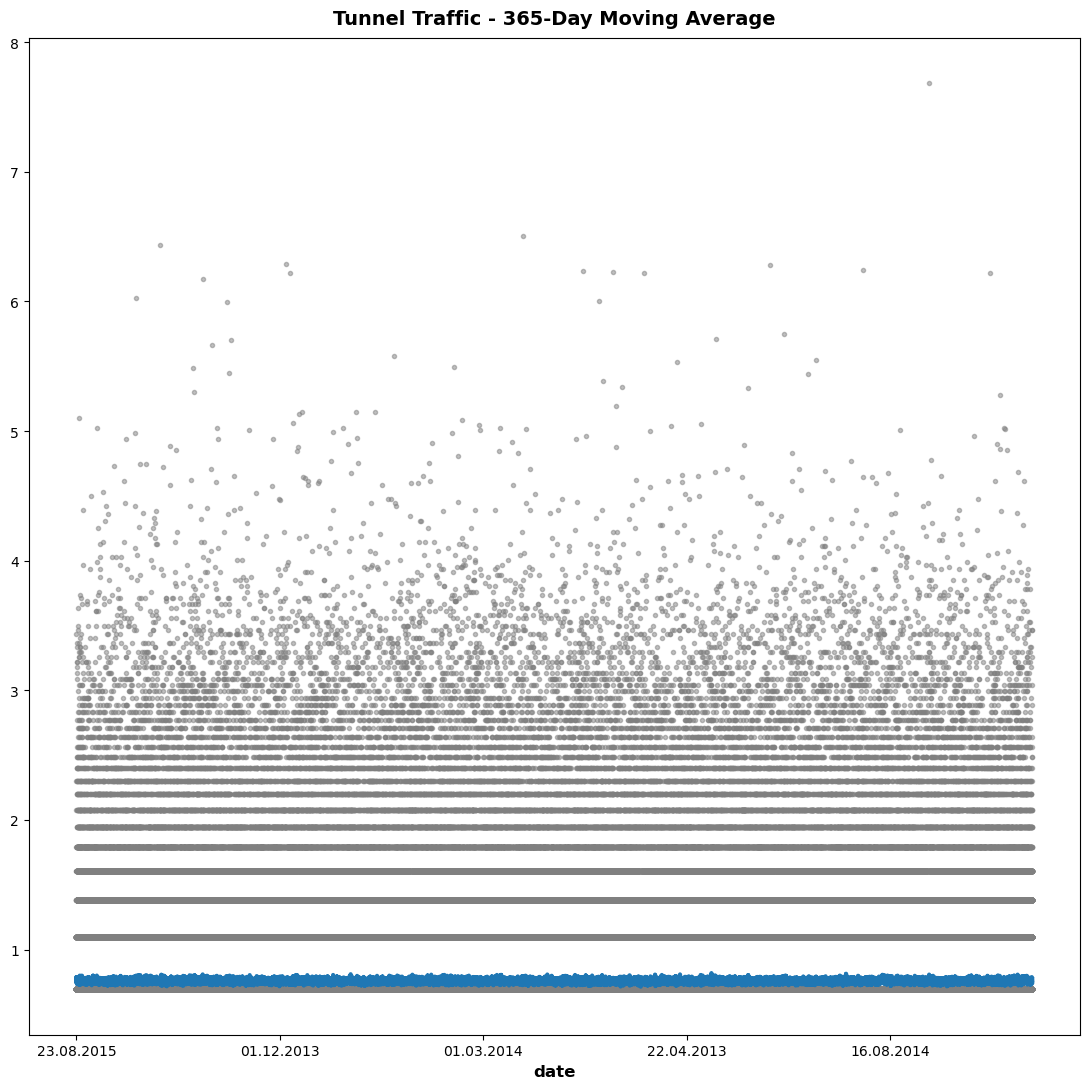

In [41]:
moving_average = np.log(y_train+1).rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = np.log(y_train+1).plot(style=".", color="0.5", alpha=0.5)
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [17]:
# measures test error.
sales_predictions_test = lin_reg.predict(X_test)
lin_mse = mean_squared_error(sales_predictions_test, y_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.159645088273082

In [12]:
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-10, penalty=None, eta0=1e-100)
sgd_reg.fit(X_train_scaled, y_train)

SGDRegressor(eta0=1e-100, max_iter=10000, penalty=None, tol=1e-10)

In [13]:
# measures training error.
sales_predictions_train = sgd_reg.predict(X_train_scaled)
sgd_mse = mean_squared_error(sales_predictions_train, y_train)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

2.9902927476979446

In [14]:
# measures test error.
sales_predictions_test = sgd_reg.predict(X_test_scaled)
sgd_mse = mean_squared_error(sales_predictions_test, y_test)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

2.4989672066652013

In [72]:
# regularized linear model. 
ridge_reg = Ridge(alpha=1, solver="sparse_cg")
ridge_reg.fit(X_train_scaled, y_train)

Ridge(alpha=1, solver='sparse_cg')

In [73]:
# measures training error.
sales_predictions_train = ridge_reg.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7135467950599668

In [74]:
# measures test error.
sales_predictions_test = ridge_reg.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.1616129585139467

In [18]:
# regularized linear model.
# unnecessary features are dropped.
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [19]:
# measures training error.
sales_predictions_train = lasso_reg.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7197873194636992

In [20]:
# measures test error.
sales_predictions_test = lasso_reg.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.168521623644962

In [21]:
# regularized linear model.
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1)

In [22]:
# measures training error.
sales_predictions_train = elastic_net.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7190832692452838

In [23]:
# measures test error.
sales_predictions_test = elastic_net.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.1676270527193062